In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight
import os
import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

In [7]:
from HNLprocessor.util import f_xsec
from HNLprocessor.util import f_v2

from HNLprocessor.util import f_xsec,f_xsec_tau
from HNLprocessor.util import f_v2,f_v2_tau
plt.style.use(hep.style.CMS) 

def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

def getf_xsec(f):
    mass = float(f.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))  

    if "Dirac" in f:
        if "tau" in f:
            return lambda x: f_xsec_tau(mass)(x)*2                      
        else:
            return lambda x: f_xsec(mass)(x)*2
    elif "mixed" in f:
        fe = float(f[f.find("fe")+2:f.find("fe")+5].replace("p","."))
        fmu = float(f[f.find("fmu")+3:f.find("fmu")+6].replace("p","."))
        ftau = float(f[f.find("ftau")+4:f.find("ftau")+7].replace("p","."))
        return lambda x: f_xsec(mass)(x)*(fe+fmu) + f_xsec_tau(mass)(x)*ftau
    else:
        if "tauType" in f:
            return f_xsec_tau(mass)
        else:
            return f_xsec(mass)
    print("ERROR: cannot find xsec function for ",f)
    return

def getf_v2(f):
    mass = float(f.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))      
    if "Dirac" in f:
        if "tau" in f:
            return lambda x: f_v2_tau(mass)(x)*2                      
        else:
            return lambda x: f_v2(mass)(x)*2
    elif "mixed" in f:
        fe = float(f[f.find("fe")+2:f.find("fe")+5].replace("p","."))
        fmu = float(f[f.find("fmu")+3:f.find("fmu")+6].replace("p","."))
        ftau = float(f[f.find("ftau")+4:f.find("ftau")+7].replace("p","."))
        print("Mixing")
        print(fe+fmu)
        print(ftau)
        return lambda x: f_v2(mass)(x)*(fe+fmu) + f_v2_tau(mass)(x)*ftau
    else:
        if "tauType" in f:
            return f_v2_tau(mass)
        else:
            return f_v2(mass)
    print("ERROR: cannot find v2 function for ",f)
    return


def loadLimitFiles(fpath,ctau_max=-1):
    arr =[]
    ctau = []
    for f in glob.glob(fpath):
        ct = f.split("/")[-1].split("_")[4].replace("pl","")
        mass = float(f.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))  
              
        func_xsec = getf_xsec(f)
        xsec = func_xsec(float(ct))
        signalName = "_".join(f.split("/")[-1].split("_")[1:-1])   
        limit = loadLimits(f)
        norm=1
        if len(limit) !=6:
            print("Problem loading limit for ",signalName)
            print(limit)
        else:
            if ctau_max>-1:
                if float(ct)<ctau_max:
                    arr.append(loadLimits(f)*xsec/norm)
                    ctau.append(float(ct))                            
            else:
                arr.append(loadLimits(f)*xsec/norm)
                ctau.append(float(ct))        
    arr = np.array(arr)
    ctau = np.array(ctau)
    return arr,ctau

from scipy.interpolate import Rbf,interp1d
from scipy import interpolate
import numpy as np
def interpolate1D(combineLimits,x,nBins=10,f="linear"):
    epsilon = 0.2
    smooth = 1
    newLimits = []
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(6):
        y = combineLimits[:,i]
        if f=="linear":
            rbfi = interp1d(x, np.log(y),fill_value="extrapolate")
        else:
            rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)            
        yi = np.exp(rbfi(xi))
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs

def plotlimit(ax,CLs,poi_values,showBands = True, legend=True,color='black'
              ,mask=None,mask1sig=None,plotObs=False,maskObs=None):

    # index mapping:
    # 0 : -2 sigma
    # 1 : -1 sigma
    # 2 : expected
    # 3 : +1 sigma
    # 4 : +2 sigma
    # 5 : obs
    if type(mask)==type(np.array([])):
        poi_expected    = poi_values[mask]
        expected_CLs = CLs[mask,2]       
    else:
        poi_expected = poi_values
        expected_CLs = CLs[:,2]

    if maskObs is not None: 
        obs_CLs    = CLs[maskObs,5]         
        poi_obs    = poi_values[maskObs]
    else:
        poi_obs      = poi_values        
        obs_CLs      = CLs[:,5]                
        
    if plotObs:
        if legend:
            ax.plot(poi_obs, obs_CLs, color=color, label=r"expected CL$_S$")
        else:
            ax.plot(poi_obs, obs_CLs, color=color, label='_nolegend_')        
    if legend:
        ax.plot(poi_expected, expected_CLs, "--", color=color, label=r"expected CL$_S$")
    else:
        ax.plot(poi_expected, expected_CLs, "--", color=color, label='_nolegend_')        
        
        
    if showBands:
        # 1 and 2 sigma bands
        if legend:
            sigOnelabel = r"expected CL$_S$ $\pm 1\sigma$"
            sigTwolabel = r"expected CL$_S$ $\pm 2\sigma$"            
        else:
            sigOnelabel = '_nolegend_'
            sigTwolabel = '_nolegend_'
            
        ax.fill_between(
            poi_values,
            CLs[:, 1],
            CLs[:, 3],
            color="limegreen",
            label=sigOnelabel,
            where=mask1sig,
        )
        ax.fill_between(
            poi_values,
            CLs[:, 0],
            CLs[:, 4],
            color="yellow",
            label=sigTwolabel,
            zorder=0,  # draw beneath 1 sigma band
        )    
        
    return ax

def plotOneMass_fpath(fpath,showBand=True,ax=None,addTheory=True,color='black',plotObs=False):
    mass = float(fpath.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))       

    
    isDirac = True if "Dirac" in fpath else False
    isTau   = True if "tauType" in fpath else False
    isMixed = True if "mixed" in fpath else False
    if isMixed:
        fe = float(fpath[fpath.find("fe")+2:fpath.find("fe")+5].replace("p","."))
        fmu = float(fpath[fpath.find("fmu")+3:fpath.find("fmu")+6].replace("p","."))
        ftau = float(fpath[fpath.find("ftau")+4:fpath.find("ftau")+7].replace("p","."))
    if isTau:
        label   = r"$m_{HNL}^\tau=%.1fGeV$"%mass
        if "/ele" in fpath:
            channel = "Electron Channel\n"+label
            lumi    = "122"
        elif "/mu" in fpath:
            channel = "Muon Channel\n"+label
            lumi    = "120"
        else:
            channel = "Ele+Mu Channel\n"+label
            lumi    = "122"            
    else:
        if "ele" in fpath:
            label = r"$m_{HNL}^e=%.1fGeV$"%mass
            channel = "Electron Channel\n"+label            
            lumi    = "122"
        else:            
            label = r"$m_{HNL}^\mu=%.1fGeV$"%mass
            channel = "Muon Channel\n"+label            
            lumi    = "120"
    if isMixed:
        label = r"$m_{HNL}=%(HNL)sGeV$, (%(fe)s,%(fmu)s,%(ftau)s)"%({"HNL":mass,"fe":fe,"fmu":fmu,"ftau":ftau})
        if "ele" in fpath:
            channel = "Electron Channel\n"+label            
            lumi    = "122"
        else:            
            channel = "Muon Channel\n"+label            
            lumi    = "120"
        #channel = "Combined Channel\n"+label    
    if len(glob.glob(fpath))==0:
        print("Cannot find files with ",fpath)
        return
    arr,ctau = loadLimitFiles(fpath)
    print(arr,ctau)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)

    plt.style.use(hep.style.CMS) 

    if ax ==None:
        fig, ax = plt.subplots(figsize=(8,6))
    ax = plotlimit(ax,arr_i,ctau_i,showBand,color=color,plotObs=plotObs)
    if addTheory:
        if isDirac:
            if 'tauType' in fpath:
                ax.plot(ctau_i,f_xsec_tau(mass)(ctau_i)*2,label="Theory")
            else:
                ax.plot(ctau_i,f_xsec(mass)(ctau_i)*2,label="Theory")
        elif isMixed:
            ax.plot(ctau_i,(f_xsec(mass)(ctau_i))*(fe+fmu)+f_xsec_tau(mass)(ctau_i)*ftau,label="Theory")
        else:
            if 'tauType' in fpath:
                ax.plot(ctau_i,f_xsec_tau(mass)(ctau_i),label="Theory")
                #ax.plot(ctau_i,f_xsec(mass)(ctau_i),label="Theory")
            else:
                ax.plot(ctau_i,f_xsec(mass)(ctau_i),label="Theory")            

    ax.set_xlabel("ctau[mm]")
    ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    if plotObs:
        ax.legend(["Observed","Expected","Theory"],title=channel,loc=1,fontsize="x-small",title_fontsize="x-small")
    else:
        ax.legend(["Expected","Theory"],title=channel,loc=1,fontsize="x-small")
        
    ytext = ax.get_ylim()[1]*0.8
    xtext  =ax.get_xlim()[0]*1.4
    ax.set_ylim(None,ax.get_ylim()[1]*4)

    if isDirac:
        ax.text(xtext,ytext,"Dirac")
    else:
        ax.text(xtext,ytext,"Majorana")        
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi=lumi)
    
    return ax

def get_masses(fpath,HNLtype="*"):
    ans =[p.split("/")[-1].split("_")[2].replace("mHNL","") for p in glob.glob(fpath+f'/*{HNLtype}*comb*.txt') if not "bkg" in p]
    return np.unique(ans)

def fill_zeros(y1,y2):
    y1_new=[]
    y2_new= []
    if (not np.any(y1))or (not np.any(y2)):
        print("Invalid ctau!")    
    for i,(iy1,iy2) in enumerate(zip(y1,y2)):
        #fill y1_new
        if iy1!=0: y1_new.append(iy1)
        elif y2[i]!=0: y1_new.append(y2[i])
        elif y1_new[i-1]!=0: y1_new.append((y1_new[i-1]+y2_new[i-1])/2)
        # fill y2_new
        if iy2!=0: y2_new.append(iy2)
        elif y1[i]!=0: y2_new.append(y1[i])
        elif y2_new[i-1]!=0: y2_new.append((y2_new[i-1]+y1_new[i-1])/2)      
    return np.array(y1_new),np.array(y2_new)

def get_ct_xing(fpath,init_ct):
    ## get limit and ctau from path
    arr,ctau = loadLimitFiles(fpath)
    ## get iterpolated limit and ctau from path    
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)
    print(arr,ctau)
    func_xsec = getf_xsec(fpath)
    ct_xing = intersect(funcs,func_xsec,init_ct)
    return ct_xing

def get_ct_xing_up(fpath):
    arr,ctau = loadLimitFiles(fpath)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)    
    func_xsec = getf_xsec(fpath)    
    ct_xing = intersect(funcs,func_xsec,int(min(ctau_i)))
    return ct_xing
def get_ct_xing_down(fpath):
    arr,ctau = loadLimitFiles(fpath)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)    
    func_xsec = getf_xsec(fpath)        
    ct_xing = intersect(funcs,func_xsec,int(max(ctau_i)))
    return ct_xing

from scipy.optimize import fsolve
def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return np.exp(funcs[i](x))-xsec(x) 
        return eq_i
    if isinstance(x0,int):
        sol =[]
        for i in range(len(funcs)):
            root= fsolve(eq(i),x0,full_output=True)  
            ## fill only the converged solution
            if root[2]==1:
                sol.append(root[0])
            else:
                sol.append([0])
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]


../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe1p0*fmu0p0*ftau0p0*_mHNL2p0_*_comb*.root
../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe1p0*fmu0p0*ftau0p0*_mHNL2p0_*_comb*.root
[[0.09434229 0.13399304 0.2046748  0.32460366 0.49908562 0.30984668]
 [0.10986697 0.15604253 0.23835547 0.37706935 0.58082023 0.3604815 ]
 [0.1394671  0.19864292 0.30778945 0.49427247 0.76686586 0.47340923]
 [0.32006994 0.45889338 0.70636125 1.13433036 1.75991833 1.08669911]
 [0.0770769  0.11191635 0.17617578 0.28993934 0.46083706 0.2714658 ]
 [0.0671741  0.09540644 0.14573364 0.23112603 0.35536159 0.22093882]] [ 800. 1000. 2000. 5000.  100.  400.]
[[0.09434229 0.13399304 0.2046748  0.32460366 0.49908562 0.30984668]
 [0.10986697 0.15604253 0.23835547 0.37706935 0.58082023 0.3604815 ]
 [0.1394671  0.19864292 0.30778945 0.49427247 0.76686586 0.47340923]
 [0.32006994 0.45889338 0.70636125 1.13433036 1.75991833 1.08669911]
 [0.0770769  0.111916

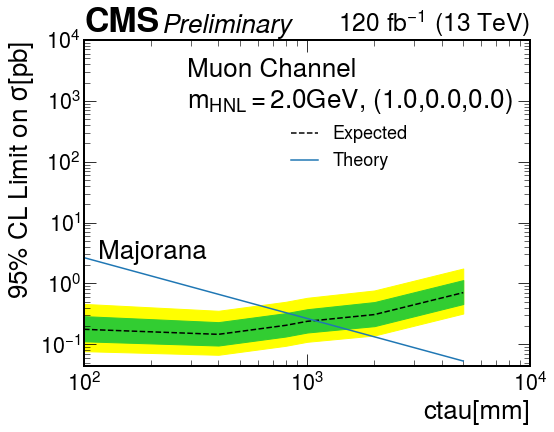

In [18]:


#basedir="../limit/combine/HNL_datacards/ele_v15_testing/"
#basedir="../limit/combine/HNL_datacards/muon_v21_testing/"
basedir="../limit/combine/HNL_datacards/combined_channel_v2/limits/"
fpath = f'{basedir}/higgsCombine_HNL_mixed*fe1p0*fmu0p0*ftau0p0*_mHNL2p0_*_comb*.root'
print(fpath)
print(fpath)
ax = plotOneMass_fpath(fpath,plotObs=False)
ax.set_ylim(None,1e4)
ax.set_xlim(1e2,1e4)
test = get_ct_xing(fpath,1000)
print(test)
print(get_ct_xing_down(fpath))

In [5]:
fpath = basedir + "/higgsCombine_HNL_mixed*fe%(fe)s*fmu%(fmu)s*ftau%(ftau)s*_mHNL2p0_*_comb*.root"
fe = 0.3
fmu = 0.3
ftau = 0.4
fpath_new = fpath%({"fe":str(fe).replace(".","p"),
                                "fmu":str(fmu).replace(".","p"),
                                "ftau":str(ftau).replace(".","p"),})
arr, ctau = loadLimitFiles(fpath_new)
#print(arr[list(ctau).index(1000)])

for fe in range(11):
    fe=fe/10
    if fe==0: continue
    for fmu in range(11):
        fmu=fmu/10
        for ftau in range (11):
            ftau= ftau/10
            if fe+fmu+ftau !=1: continue
    
            fpath_new = fpath%({"fe":str(fe).replace(".","p"),
                                            "fmu":str(fmu).replace(".","p"),
                                            "ftau":str(ftau).replace(".","p"),})
            arr, ctau = loadLimitFiles(fpath_new)
            print(fe,fmu,ftau)
            print(arr[list(ctau).index(1000)])
            print(arr[list(ctau).index(2000)])


0.1 0.0 0.9
[ 3.24035756  4.62382753  7.09001312 11.24439436 17.12733872 10.77719453]
[ 4.21318447  6.04944025  9.378915   15.13616711 23.08276533 14.45205696]
0.1 0.1 0.8
[ 3.04837011  4.32955744  6.61341312 10.48853134 16.1263592  10.06455618]
[ 3.93033276  5.62448775  8.7492625  14.12000317 21.63064699 13.46425959]
0.1 0.2 0.7
[ 2.83351375  3.99851112  6.14728406  9.74927445 14.98973498  9.33263869]
[ 3.63964556  5.20850093  8.1021675  13.01109603 20.00510974 12.45495591]
0.1 0.3 0.6
[ 2.60076609  3.69383172  5.64234     8.94845925 13.75846208  8.58082067]
[ 3.34112285  4.78130115  7.43763    11.94392979 18.36429584 11.42352613]
0.1 0.4 0.5
[ 2.37083491  3.36726367  5.14350625  8.15733508 12.54209102  7.80850002]
[ 3.02614316  4.35953749  6.73645781 10.87163624 16.80462736 10.36922731]
0.1 0.5 0.4
[ 2.13286383  3.02927667  4.62723     7.32010318 11.27554842  7.01488185]
[ 2.72057095  3.8932627   6.0562275   9.67728463 15.07077375  9.29155117]
0.1 0.6 0.3
[1.88001642 2.67016103 4.078

In [47]:
print(fpath[fpath.find("fmu")+3:fpath.find("fmu")+6])
print(fpath[fpath.find("fe")+2:fpath.find("fe")+5])
print(fpath[fpath.find("ftau")+4:fpath.find("ftau")+7])

1p0
0p0
0p0


In [195]:
import os
basedir="../limit/combine/HNL_datacards/ele_v14_testing/"
basedir="../limit/combine/HNL_datacards/muon_v20_testing/"
basedir="../limit/combine/HNL_datacards/combined_channel_v2/limits/"
d = dict()

fpath = basedir + "/higgsCombine_HNL_mixed*fe%(fe)s*fmu%(fmu)s*ftau%(ftau)s*_mHNL2p0_*_comb*.root"
print(fpath)
for fe in range(11):
    #if fe==0: continue
    fe=fe/10
    for fmu in range(11):
        fmu=fmu/10
        for ftau in range (11):
            ftau= ftau/10
            
            if round(fe+fmu+ftau,2) !=1: continue
            fpath_new = fpath%({"fe":str(fe).replace(".","p"),
                                "fmu":str(fmu).replace(".","p"),
                                "ftau":str(ftau).replace(".","p"),})
            #print(fpath_new)
            #print(get_ct_xing(fpath_new,1500))
            print(fpath_new)
            arr, ctau = loadLimitFiles(fpath_new)
            if not list(arr): continue
            #if 1000 not in list(ctau): continue
            #d[(fe*10,fmu*10,ftau*10)] = arr[list(ctau).index(1000)][-1]
            d[(fe*10,fmu*10,ftau*10)]=get_ct_xing(fpath_new,1000)[-1]
print(d)
#ax = plotOneMass_fpath(fpath,plotObs=False)
#ax.set_ylim(None,1e4)
#ax.set_xlim(1e2,1e4)
#test = get_ct_xing(fpath,1500)
#print(test)
#print(get_ct_xing_down(fpath))

../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe%(fe)s*fmu%(fmu)s*ftau%(ftau)s*_mHNL2p0_*_comb*.root
../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe0p0*fmu0p0*ftau1p0*_mHNL2p0_*_comb*.root
Problem loading limit for  HNL_mixed-fe0p0-fmu0p0-ftau1p0_mHNL2p0_pl2000
[ 3984.375      21263.52851562]
Problem loading limit for  HNL_mixed-fe0p0-fmu0p0-ftau1p0_mHNL2p0_pl2000
[ 3984.375      21263.52851562]
[[  5.07832031   6.98269043  10.15664062  15.13627207  21.90324341
   11.71511254]
 [  5.94351562   8.17233398  11.88703125  17.71504301  25.63490652
   13.69322681]
 [ 24.11750742  33.02135464  47.8611      71.32659576 103.50446726
   55.07437312]
 [  4.22135376   5.82058934   8.57671875  12.98686331  19.12452853
   10.61986963]
 [  3.51720703   4.83615967   7.03441406  10.48327004  15.21263147
    8.1582186 ]] [ 800. 1000. 5000.  100.  400.]
../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixe

[[0.5407566  0.7499779  1.09868008 1.66362081 2.44330546 1.36769332]
 [0.44247754 0.60840662 0.88495508 1.31883379 1.91380484 1.05150475]
 [0.63783555 0.87702388 1.27567109 1.90111129 2.7587676  1.51423391]
 [0.74536594 1.02487816 1.49073187 2.22161277 3.22385815 1.77035816]
 [1.42699006 1.95381488 2.83185625 4.19769225 6.07690721 3.40436327]] [ 100.  400.  800. 1000. 2000.]
../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe0p1*fmu0p4*ftau0p5*_mHNL2p0_*_comb*.root
[[0.45731384 0.62880653 0.91462769 1.36670007 1.98003976 1.05844348]
 [0.53498223 0.73560056 1.06996445 1.59455008 2.31390613 1.23747034]
 [1.00871439 1.37534327 1.98639141 2.95236792 4.26716249 2.32184581]
 [2.17405501 2.97668579 4.31440375 6.39528903 9.20578763 5.01565831]
 [0.38965388 0.54041283 0.79167773 1.19875809 1.76057666 0.96140055]
 [0.31787061 0.43707208 0.63574121 0.94743452 1.37485465 0.73476876]] [ 800. 1000. 2000. 5000.  100.  400.]
../limit/combine/HNL_datacards/combined_chan

[[0.10622363 0.1460575  0.21244727 0.31660662 0.45943867 0.24540506]
 [0.12480872 0.17088636 0.24768242 0.37109152 0.53675668 0.28686959]
 [0.2178718  0.29705981 0.42903984 0.6376807  0.92166263 0.50174417]
 [0.50689399 0.69113047 0.99819125 1.48360886 2.13825116 1.16449175]
 [0.09061293 0.12512789 0.18265283 0.27730089 0.40658311 0.2218503 ]
 [0.07351453 0.10108247 0.14702905 0.22028707 0.31862909 0.17039848]] [ 800. 1000. 2000. 5000.  100.  400.]
../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe0p3*fmu0p0*ftau0p7*_mHNL2p0_*_comb*.root
Problem loading limit for  HNL_mixed-fe0p3-fmu0p0-ftau0p7_mHNL2p0_pl400
[]
Problem loading limit for  HNL_mixed-fe0p3-fmu0p0-ftau0p7_mHNL2p0_pl400
[]
[[ 0.85534201  1.20922628  1.84006348  2.89624172  4.43558487  2.76923296]
 [ 0.99630237  1.40850678  2.14330594  3.37354255  5.1665694   3.2240783 ]
 [ 1.275348    1.8164776   2.81456109  4.49740516  6.94050955  4.29674456]
 [ 2.92849782  4.17105819  6.46289175 10.327096

[[0.120797   0.16609587 0.24159399 0.3600435  0.52247144 0.30878974]
 [0.14094062 0.19379336 0.28188125 0.4212065  0.61023306 0.36116637]
 [0.2213694  0.30701828 0.44976641 0.6738649  0.98011656 0.58306743]
 [0.51251607 0.71081098 1.0413025  1.56428771 2.27149159 1.35148961]
 [0.10057139 0.13927252 0.20597021 0.31188    0.46050455 0.27175808]] [ 800. 1000. 2000. 5000.  100.]
../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe0p5*fmu0p0*ftau0p5*_mHNL2p0_*_comb*.root
Problem loading limit for  HNL_mixed-fe0p5-fmu0p0-ftau0p5_mHNL2p0_pl2000
[]
Problem loading limit for  HNL_mixed-fe0p5-fmu0p0-ftau0p5_mHNL2p0_pl2000
[]
[[0.42849745 0.60858893 0.92962158 1.47433179 2.26681907 1.40804156]
 [0.49982154 0.70988954 1.08435859 1.71541436 2.64234509 1.63853323]
 [1.45530759 2.0965525  3.23964125 5.1766437  8.06176832 4.96269461]
 [0.35029491 0.50863133 0.80067407 1.31770049 2.07693342 1.24193064]
 [0.30547721 0.43386501 0.66273022 1.04841417 1.61492886 1.00499945]]

[[0.12043519 0.1682528  0.25066187 0.38554696 0.57241513 0.35992186]
 [0.13927278 0.1954421  0.29224453 0.44950593 0.66737393 0.41934625]
 [0.18691149 0.26424318 0.40209531 0.63129132 0.9501046  0.58795701]
 [0.43008913 0.60803173 0.92523375 1.45262083 2.19685208 1.35068538]
 [0.09768708 0.13939456 0.21374268 0.33728088 0.51560582 0.31472463]
 [0.08457611 0.11868603 0.17747119 0.27226384 0.40491937 0.25403013]] [ 800. 1000. 2000. 5000.  100.  400.]
../limit/combine/HNL_datacards/combined_channel_v2/limits//higgsCombine_HNL_mixed*fe0p8*fmu0p0*ftau0p2*_mHNL2p0_*_comb*.root
[[0.17949888 0.25493974 0.38942129 0.6160498  0.94893466 0.58957472]
 [0.20847382 0.29609245 0.45228219 0.71729616 1.10285934 0.68523729]
 [0.26513264 0.37762831 0.58512031 0.93963214 1.45784325 0.90049765]
 [0.60994839 0.86874923 1.346093   2.15093072 3.34971958 2.06711946]
 [0.14615653 0.21222059 0.33407207 0.54979542 0.87385901 0.51844574]
 [0.12756265 0.18117545 0.27674609 0.43890499 0.67482656 0.42056178]] [ 800. 

In [198]:
#d = {key:val for key, val in d.items() if val != 0}
d[(10.0, 0.0, 0.0)]=1100

In [197]:
for i,j in d.items():
    print(i,j)
print("min: ",min(d.values()))
print("max: ",max(d.values()))

(0.0, 0.0, 10.0) 89.87567824446398
(0.0, 1.0, 9.0) 275.3673877840477
(0.0, 2.0, 8.0) 475.61392255340064
(0.0, 3.0, 7.0) 594.7362162055305
(0.0, 4.0, 6.0) 645.7782286045262
(0.0, 5.0, 5.0) 785.3726174733777
(0.0, 6.0, 4.0) 867.6882240982076
(0.0, 7.0, 3.0) 943.4415525348332
(0.0, 8.0, 2.0) 1013.7645129512734
(0.0, 9.0, 1.0) 1087.688298089804
(0.0, 10.0, 0.0) 1157.4039083844298
(1.0, 0.0, 9.0) 140.12090568732555
(1.0, 1.0, 8.0) 283.6345688036492
(1.0, 2.0, 7.0) 451.9876405878122
(1.0, 3.0, 6.0) 561.4125076147506
(1.0, 4.0, 5.0) 659.5673854548787
(1.0, 5.0, 4.0) 747.487761470181
(1.0, 6.0, 3.0) 828.400239368741
(1.0, 7.0, 2.0) 906.0473350806707
(1.0, 8.0, 1.0) 976.2217532182938
(1.0, 9.0, 0.0) 1046.5786985232555
(2.0, 0.0, 8.0) 244.86376133137045
(2.0, 1.0, 7.0) 371.1800251464238
(2.0, 2.0, 6.0) 480.64133639029245
(2.0, 3.0, 5.0) 572.6670362370036
(2.0, 4.0, 4.0) 659.7576327258719
(2.0, 5.0, 3.0) 711.0415110245129
(2.0, 6.0, 2.0) 814.9242787942915
(2.0, 7.0, 1.0) 888.7875403819947
(2.0, 8

In [61]:
def get_limits(basedir,HNLtype,masses_up,masses_down,debug=False):
    masses_str = get_masses(basedir,HNLtype)
    fpaths = []
    print("Available masses = ",masses_str)
    for mass_str in masses_str:
        fpaths.append( f'{basedir}higgsCombine_HNL_*{HNLtype}*_mHNL{mass_str}_pl*_comb.Asym*.root') 
    ct_up,limits_up,m_up =[], [],[]
    ct_down,limits_down,m_down =[], [],[]   

    for fpath in fpaths:
        print(fpath)
        mass = float(fpath.split("/")[-1].split("_")[3].replace("mHNL","").replace("p","."))
        func_v2 = getf_v2(fpath)        
        if mass in masses_up:
            ct_xing_up = get_ct_xing_up(fpath)
            if debug:
                print(mass,ct_xing_up)              
            m_up.append(mass)              
        if mass in masses_down:
            ct_xing_down = get_ct_xing_down(fpath)
            if debug:
                print(mass,ct_xing_down)            
            m_down.append(mass)
        ## Fill the invalid limit points
        if mass in masses_up and mass in masses_down:
            y_up_new, y_down_new = fill_zeros(ct_xing_up,ct_xing_down)            
            ct_up.append(y_up_new)
            ct_down.append(y_down_new)            
            limits_up.append(func_v2(y_up_new))
            limits_down.append(func_v2(y_down_new))
            if debug:
                print(mass,y_up_new)     
                print(mass,y_down_new)
        elif mass in masses_up:
            if debug: print(mass,ct_xing_up)                        
            ct_up.append(ct_xing_up)                
            limits_up.append(func_v2(ct_xing_up))
        elif mass in masses_down:
            if debug: print(mass,ct_xing_down)            
            ct_down.append(ct_xing_down)
            limits_down.append(func_v2(ct_xing_down))       
    result= {
        'm_up': np.array(m_up),
        'limit_up':np.array(limits_up),
        'm_down': np.array(m_down),
        'limit_down':np.array(limits_down),        
        'ct_up':np.array(ct_up),
        'ct_down':np.array(ct_down),        
    }
    return result 

In [68]:
pip install python-ternary

You should consider upgrading via the '/uscms/home/jschindl/nobackup/HNL/coffeaenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [173]:
# Make images higher resolution and set default size
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (4, 4)


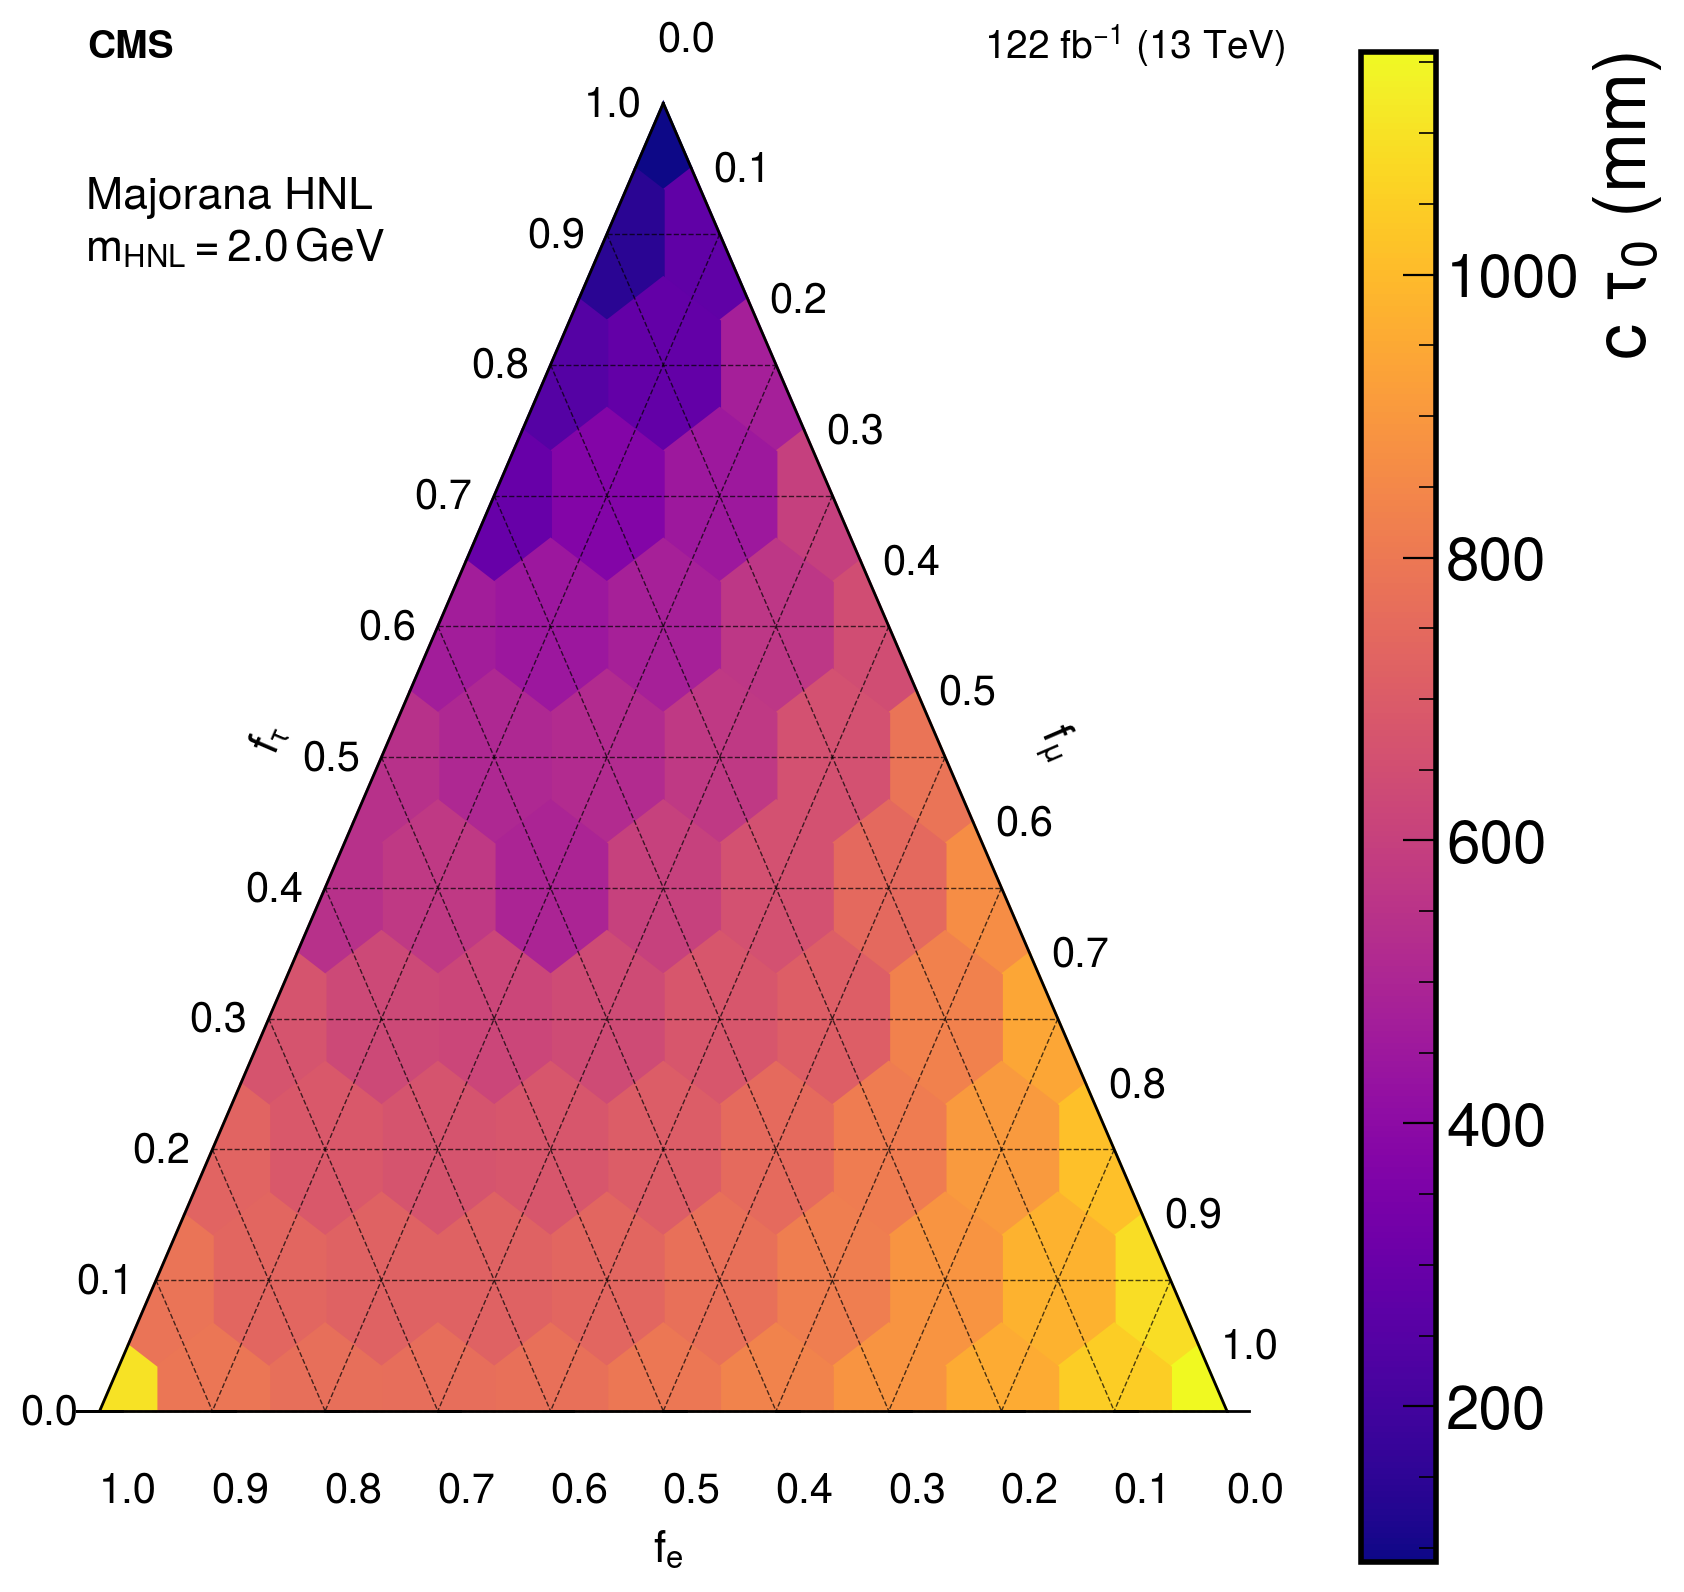

In [199]:
import ternary
from matplotlib.ticker import FormatStrFormatter
## Boundary and Gridlines
scale = 10.0
figure, tax = ternary.figure(scale=scale,permutation="120")

tax.heatmap(d,style="h",cmap="plasma",cbarlabel="c $\\tau_0$ (mm)" )
# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="black", multiple=1,linestyle="--",alpha=0.7)
#tax.gridlines(color="blue", multiple=1, linewidth=0.5)

# Set Axis labels and Title
fontsize = 16
offset = 0.12
tax.set_title("", fontsize=fontsize)
tax.left_axis_label("      $f_{\\tau}$", fontsize=fontsize, offset=offset)
tax.right_axis_label("$f_{\\mu}$      ", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("      $f_e$      ", fontsize=fontsize, offset=0)

# Set ticks

tax.ticks(ticks = [x/10 for x in range(11)],axis='blr',permutation='120', clockwise=True, linewidth=1, multiple=1, offset=0.02,tick_formats="%.1f",fontsize=15)



# Background color
tax.set_background_color(color="white", alpha=0.7) # the detault, essentially


# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.top_corner_label("Majorana HNL\n $m_{HNL}=2.0 \, \mathrm{GeV}$",position = (-0.35,1,0),fontsize=fontsize)
tax.right_corner_label("CMS",position = (-0.505,1.15,0),fontsize=14,fontweight="bold")
tax.left_corner_label("122 $\mathrm{fb}^{-1}$ (13 TeV)",position = (0.305,1.15,0),fontsize=14)

ax = tax.get_axes()

tax.get_axes().axis('off')
plt.style.use(hep.style.CMS) 

tax.show()
tax.savefig("Ternary_plot_2GeV_Majorana.pdf")

In [87]:
[x/10 for x in range(11)]

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

{(0, 0, 20): 0.02378159527289536, (0, 1, 19): 0.889551594722519, (0, 2, 18): 0.3201581120007141, (0, 3, 17): 0.5669138346019631, (0, 4, 16): 0.1594726651745908, (0, 5, 15): 0.46312687118983764, (0, 6, 14): 0.8581409713176639, (0, 7, 13): 0.6474416719461147, (0, 8, 12): 0.2835102430464439, (0, 9, 11): 0.9915749624599828, (0, 10, 10): 0.8527094080270667, (0, 11, 9): 0.31307795992120846, (0, 12, 8): 0.709481287362411, (0, 13, 7): 0.8499254968535447, (0, 14, 6): 0.797655874800785, (0, 15, 5): 0.7251545118415429, (0, 16, 4): 0.5516354916095385, (0, 17, 3): 0.6570094401539183, (0, 18, 2): 0.26996374407543555, (0, 19, 1): 0.4330925329281643, (0, 20, 0): 0.33448708558443563, (1, 0, 19): 0.619961926874586, (1, 1, 18): 0.41568132232202326, (1, 2, 17): 0.9904101380938778, (1, 3, 16): 0.1256532595537675, (1, 4, 15): 0.24916593508698115, (1, 5, 14): 0.8721654143041395, (1, 6, 13): 0.41078168415217575, (1, 7, 12): 0.7193732829568332, (1, 8, 11): 0.9386785278369393, (1, 9, 10): 0.46246124678381584, (

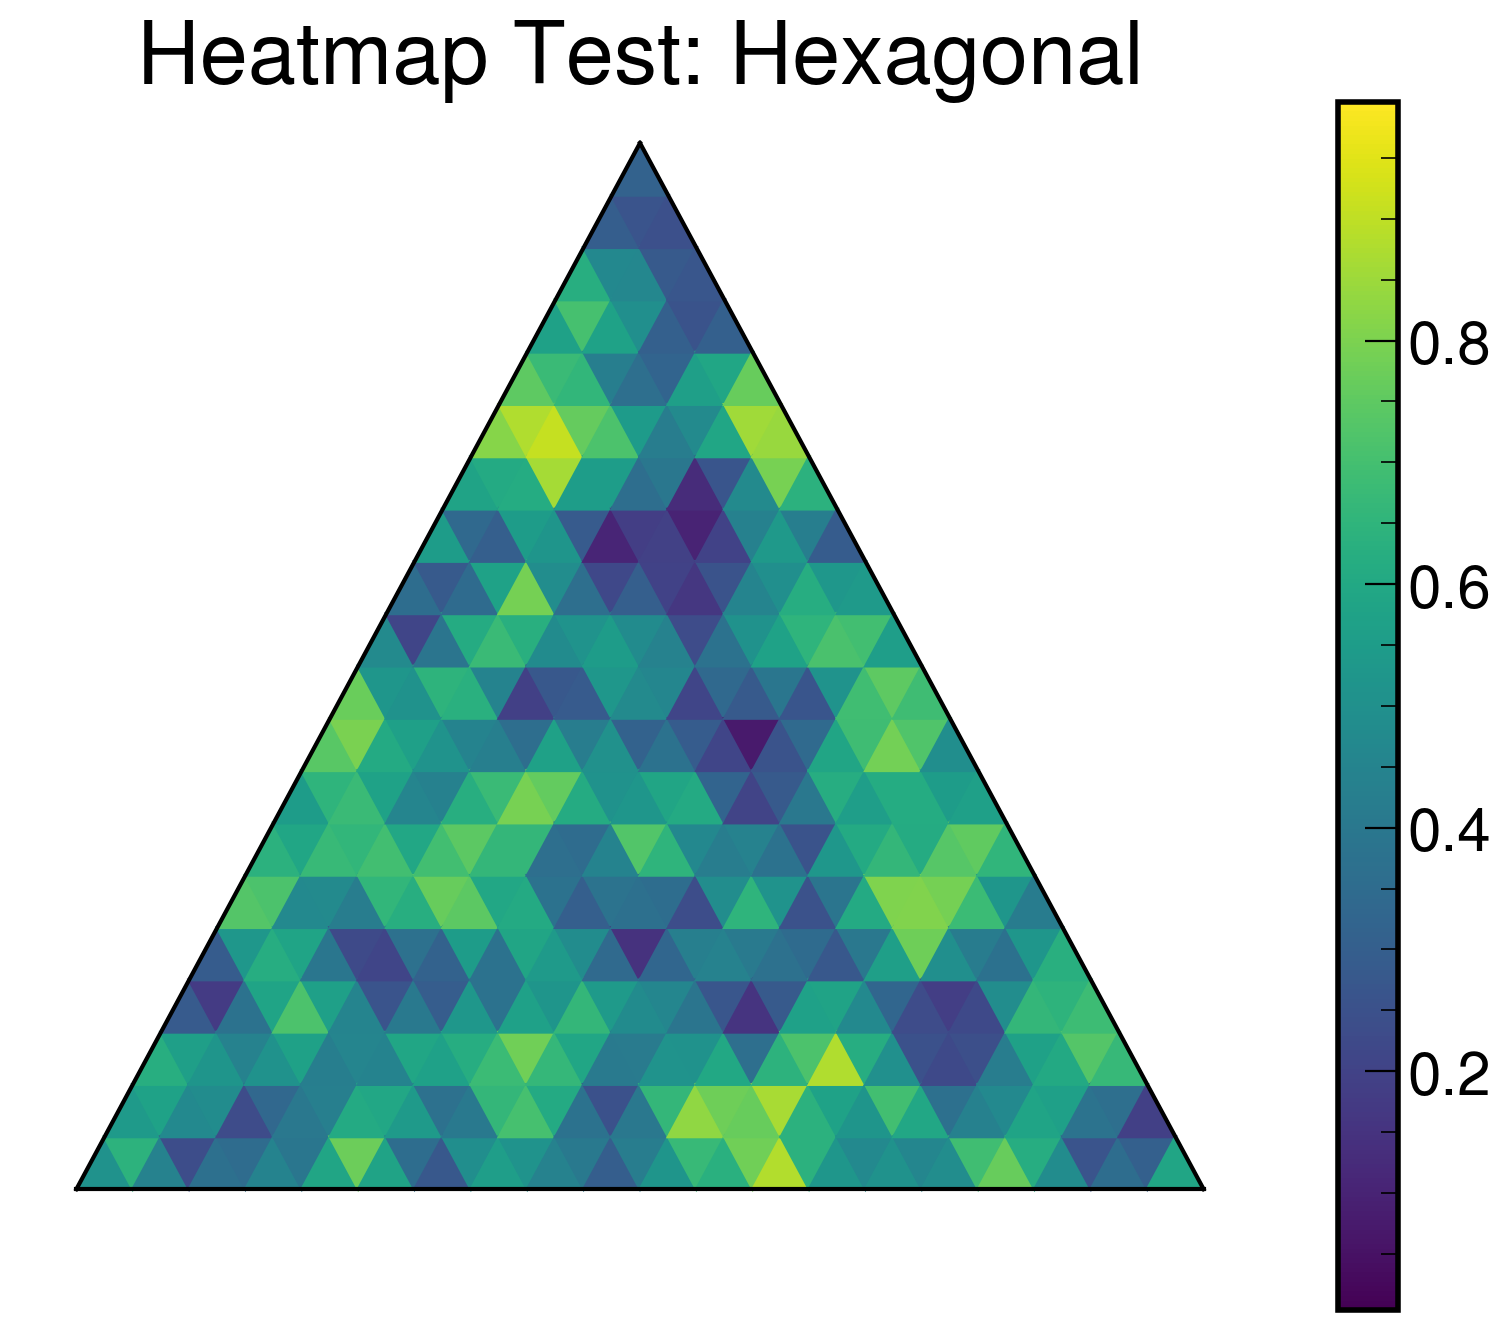

In [102]:
import random
def generate_random_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i,j,k) in simplex_iterator(scale):
        d[(i,j,k)] = random.random()
    return d

scale = 20
d = generate_random_heatmap_data(scale)
print(d)
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 8)
tax.heatmap(d)
tax.boundary()
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.set_title("Heatmap Test: Hexagonal")

In [4]:
for i in range(51):
    print(i/50)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0


In [55]:
count = 0
for fe in range(51):

    fe=fe/50


    for fmu in range(51):
        fmu=fmu/50


        for ftau in range(51):
            ftau=ftau/50


            if fe+fmu+ftau!=1: continue
            count +=1
            mixed_sample_name = "HNL_mixed-fe{}-fmu{}-ftau{}".format(fe,fmu,ftau).replace(".","p")
            print(mixed_sample_name)
print(count)

HNL_mixed-fe0p0-fmu0p0-ftau1p0
HNL_mixed-fe0p0-fmu0p02-ftau0p98
HNL_mixed-fe0p0-fmu0p04-ftau0p96
HNL_mixed-fe0p0-fmu0p06-ftau0p94
HNL_mixed-fe0p0-fmu0p08-ftau0p92
HNL_mixed-fe0p0-fmu0p1-ftau0p9
HNL_mixed-fe0p0-fmu0p12-ftau0p88
HNL_mixed-fe0p0-fmu0p14-ftau0p86
HNL_mixed-fe0p0-fmu0p16-ftau0p84
HNL_mixed-fe0p0-fmu0p18-ftau0p82
HNL_mixed-fe0p0-fmu0p2-ftau0p8
HNL_mixed-fe0p0-fmu0p22-ftau0p78
HNL_mixed-fe0p0-fmu0p24-ftau0p76
HNL_mixed-fe0p0-fmu0p26-ftau0p74
HNL_mixed-fe0p0-fmu0p28-ftau0p72
HNL_mixed-fe0p0-fmu0p3-ftau0p7
HNL_mixed-fe0p0-fmu0p32-ftau0p68
HNL_mixed-fe0p0-fmu0p34-ftau0p66
HNL_mixed-fe0p0-fmu0p36-ftau0p64
HNL_mixed-fe0p0-fmu0p38-ftau0p62
HNL_mixed-fe0p0-fmu0p4-ftau0p6
HNL_mixed-fe0p0-fmu0p42-ftau0p58
HNL_mixed-fe0p0-fmu0p44-ftau0p56
HNL_mixed-fe0p0-fmu0p46-ftau0p54
HNL_mixed-fe0p0-fmu0p48-ftau0p52
HNL_mixed-fe0p0-fmu0p5-ftau0p5
HNL_mixed-fe0p0-fmu0p52-ftau0p48
HNL_mixed-fe0p0-fmu0p54-ftau0p46
HNL_mixed-fe0p0-fmu0p56-ftau0p44
HNL_mixed-fe0p0-fmu0p58-ftau0p42
HNL_mixed-fe0p0-fmu0p6

HNL_mixed-fe0p84-fmu0p16-ftau0p0
HNL_mixed-fe0p86-fmu0p0-ftau0p14
HNL_mixed-fe0p86-fmu0p02-ftau0p12
HNL_mixed-fe0p86-fmu0p04-ftau0p1
HNL_mixed-fe0p86-fmu0p08-ftau0p06
HNL_mixed-fe0p86-fmu0p1-ftau0p04
HNL_mixed-fe0p86-fmu0p12-ftau0p02
HNL_mixed-fe0p86-fmu0p14-ftau0p0
HNL_mixed-fe0p88-fmu0p0-ftau0p12
HNL_mixed-fe0p88-fmu0p02-ftau0p1
HNL_mixed-fe0p88-fmu0p04-ftau0p08
HNL_mixed-fe0p88-fmu0p06-ftau0p06
HNL_mixed-fe0p88-fmu0p08-ftau0p04
HNL_mixed-fe0p88-fmu0p1-ftau0p02
HNL_mixed-fe0p88-fmu0p12-ftau0p0
HNL_mixed-fe0p9-fmu0p0-ftau0p1
HNL_mixed-fe0p9-fmu0p02-ftau0p08
HNL_mixed-fe0p9-fmu0p04-ftau0p06
HNL_mixed-fe0p9-fmu0p06-ftau0p04
HNL_mixed-fe0p9-fmu0p08-ftau0p02
HNL_mixed-fe0p9-fmu0p1-ftau0p0
HNL_mixed-fe0p92-fmu0p0-ftau0p08
HNL_mixed-fe0p92-fmu0p02-ftau0p06
HNL_mixed-fe0p92-fmu0p04-ftau0p04
HNL_mixed-fe0p92-fmu0p06-ftau0p02
HNL_mixed-fe0p92-fmu0p08-ftau0p0
HNL_mixed-fe0p94-fmu0p0-ftau0p06
HNL_mixed-fe0p94-fmu0p02-ftau0p04
HNL_mixed-fe0p94-fmu0p04-ftau0p02
HNL_mixed-fe0p94-fmu0p06-ftau0p0
HNL

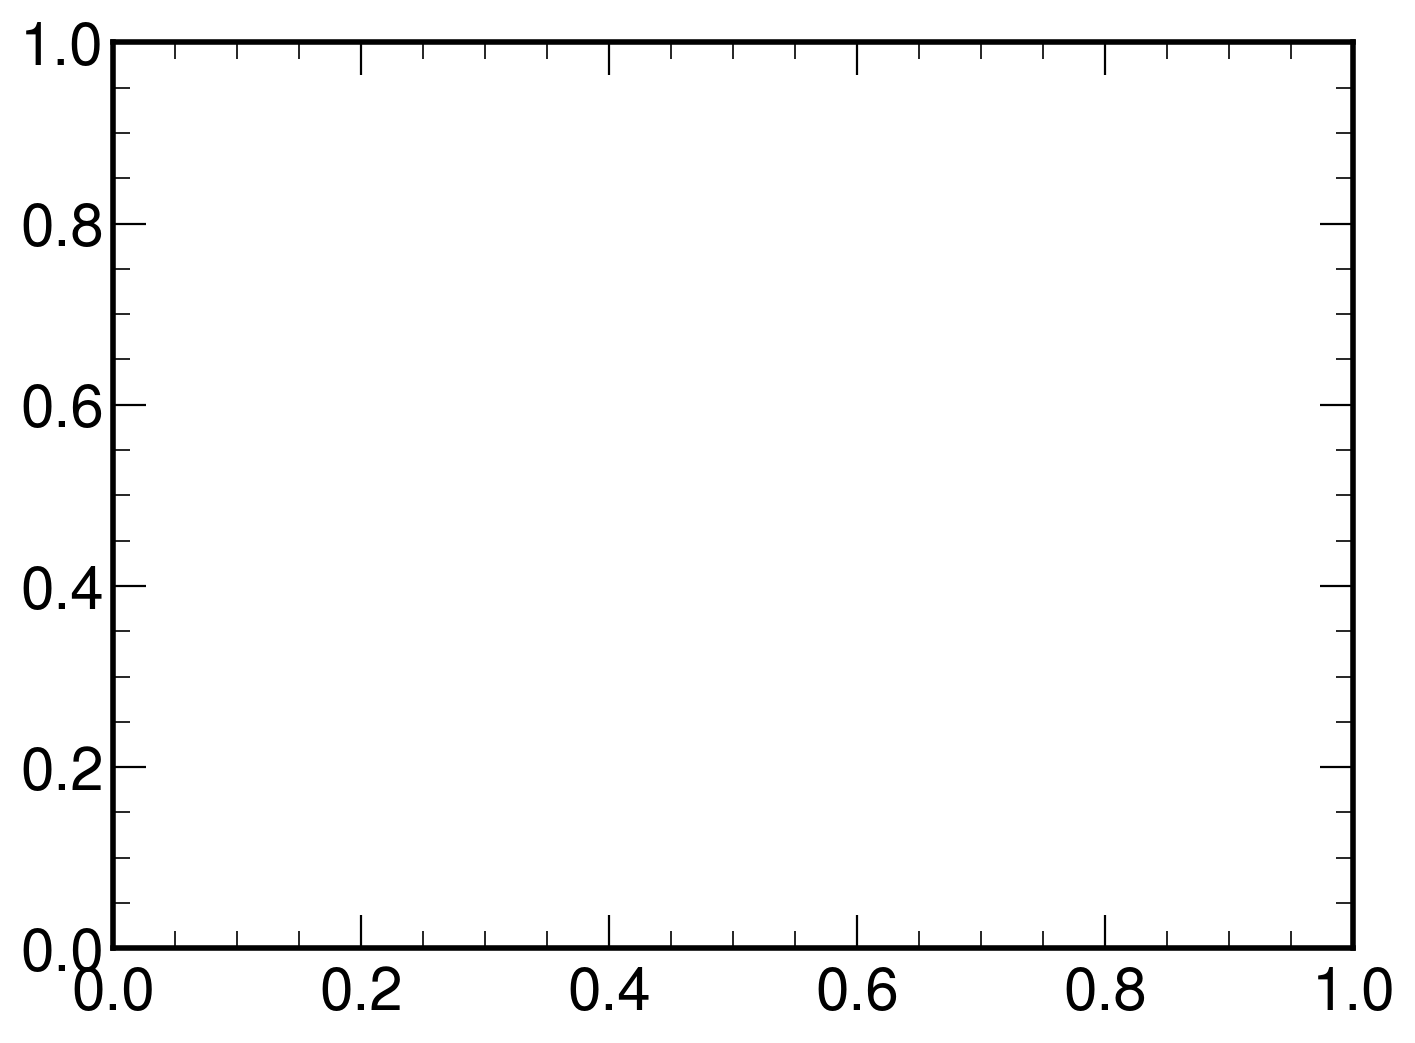

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ctau_i,f_xsec_tau(mass)(ctau_i)*2,label="Theory")

In [112]:
def plot_1D_mixing(target,target_mixing,x_axsis):
    if target==x_axsis:
        print("Same x axis and fixed mixing")
        return
    count = 0
    list_of_keys = []
    x_array = []
    y_array = []
    for fe in range(11):
        
        fe=fe/10
        if target=="fe" and fe!=target_mixing: continue

        for fmu in range(11):
            fmu=fmu/10
            if target=="fmu" and fmu!=target_mixing: continue

            for ftau in range(11):
                ftau=ftau/10
                if target=="ftau" and ftau!=target_mixing: continue

                if fe+fmu+ftau!=1: continue
                
                if (fe*10,fmu*10,ftau*10) in d:
                    if x_axsis=="fe":
                        x_array.append(fe)
                    elif x_axsis=="fmu":
                        x_array.append(fmu)
                    elif x_axsis=="ftau":
                        x_array.append(ftau)   
                    #print(d[(fe*10,fmu*10,ftau*10)])
                    print(fe,fmu,ftau,d[(fe*10,fmu*10,ftau*10)])
                    y_array.append(d[(fe*10,fmu*10,ftau*10)])
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(x_array,y_array,label=target + str(target_mixing))
    ytext = ax.get_ylim()[1]*0.8
    xtext  =ax.get_xlim()[0]*1.4
    #ax.set_ylim(None,ax.get_ylim()[1]*4)
    ax.legend([target +"   " +str(target_mixing)],title="Combined",loc=1,fontsize="x-small")
    ax.set_xlabel(x_axsis)
    ax.set_ylabel("95% CL Limit on ctau[mm]")
    #ax.text(xtext,ytext,"Majorana")        
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi=120)

0.0 0.3 0.7 577.0643515027373
0.2 0.3 0.5 555.1102059800152
0.3 0.3 0.4 587.7118963893278
0.4 0.3 0.3 627.4460243783891
0.5 0.3 0.2 670.5816693698434
0.7 0.3 0.0 759.2394081607054


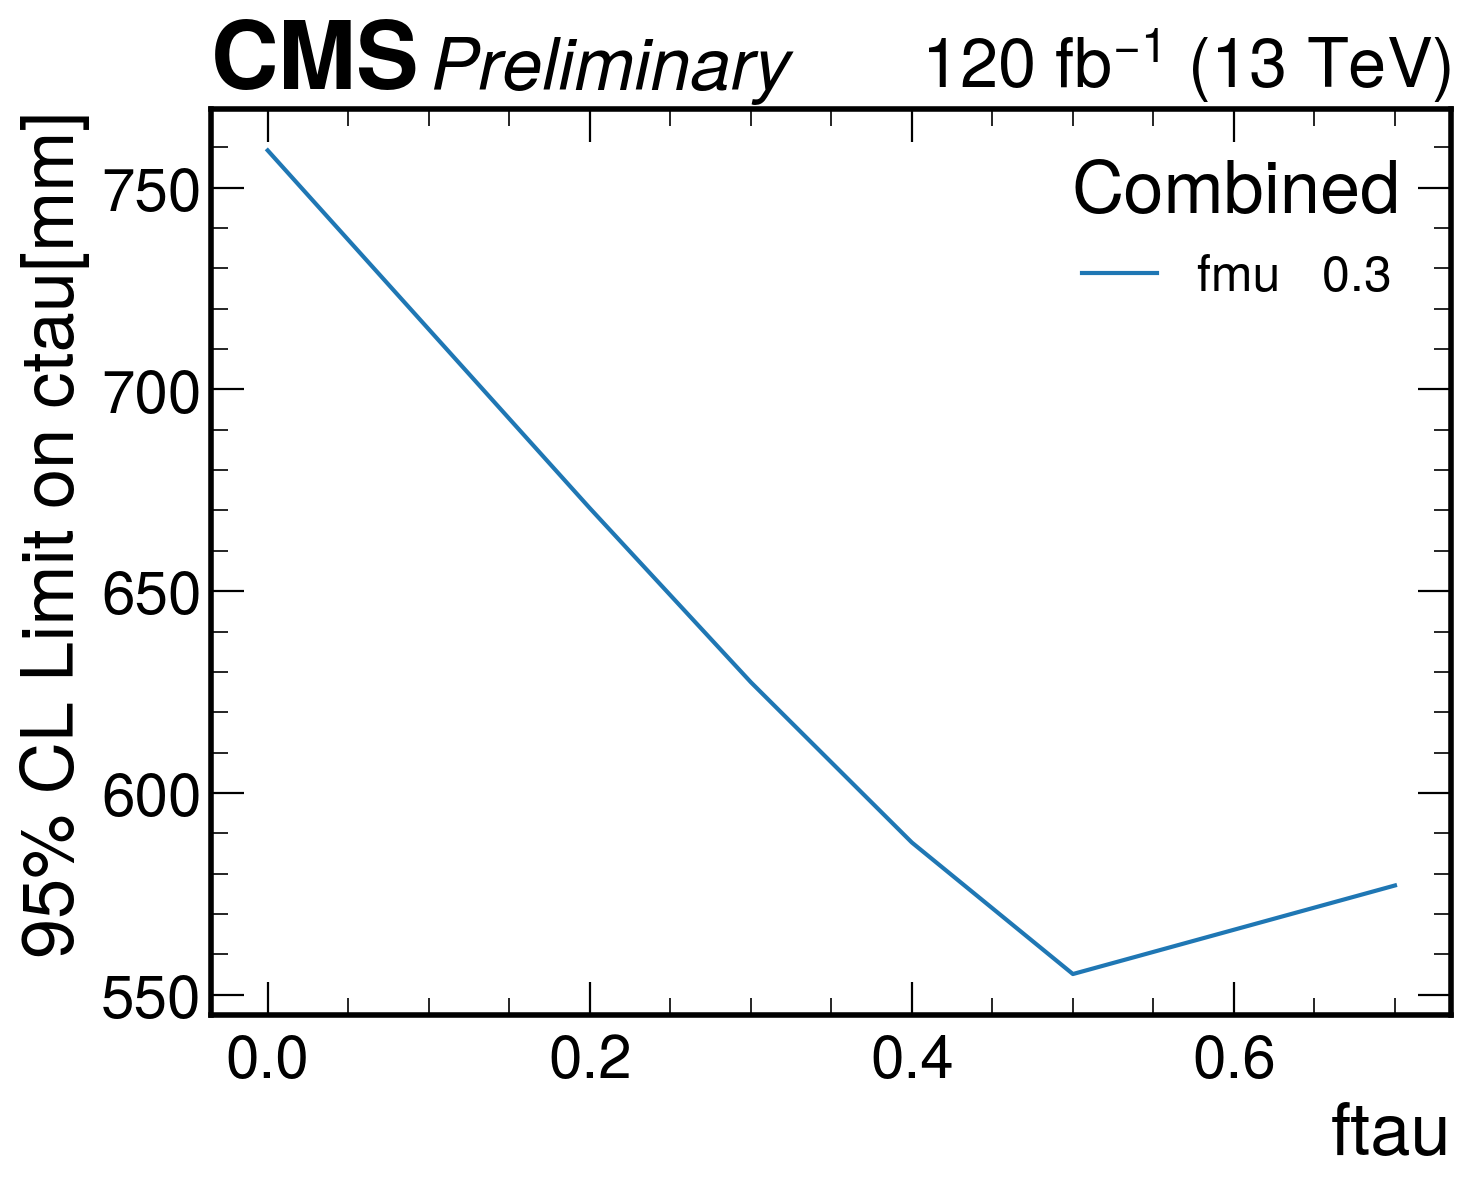

In [114]:
plot_1D_mixing("fmu",0.3,"ftau")

In [125]:
problem_points = [
        (0.1,0.2,0.7),
        (0.1,0.3,0.6),
        (0.1,0.6,0.3),
        (0.1,0.7,0.2),
        (0.2,0.7,0.1),
        (0.3,0.6,0.1),
        (0.6,0.3,0.1),
        (0.7,0.2,0.1),
        ]

In [127]:
for fe in range(11):
        
        fe=fe/10.0
    
        for fmu in range(11):
            fmu=fmu/10.0
            

            for ftau in range(11):
                ftau=ftau/10.0
                if (fe,fmu,ftau) in problem_points:
                    print((fe,fmu,ftau))

(0.1, 0.2, 0.7)
(0.1, 0.3, 0.6)
(0.1, 0.6, 0.3)
(0.1, 0.7, 0.2)
(0.2, 0.7, 0.1)
(0.3, 0.6, 0.1)
(0.6, 0.3, 0.1)
(0.7, 0.2, 0.1)


In [12]:
0.1+0.2+0.7

1.0

In [20]:
0.3+0.6+0.1==1.0

False

In [21]:
round(0.3+0.6+0.1)==1.0

True